In [34]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sdv.tabular import GaussianCopula
from sdv.evaluation import evaluate
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")



In [39]:
df_1 = pd.read_csv('download_data/train.csv')
df_2 = pd.read_csv('download_data/test.csv')
df_2_target = pd.read_csv('download_data/sample_submission.csv')

# merge train, test subsample
# -> GarageYrBlt: drop column
df_1.drop(['Id','GarageYrBlt'],axis=1,inplace=True)
df_2.drop(['Id','GarageYrBlt'],axis=1,inplace=True)
df_2_target.drop(['Id'],axis=1,inplace=True)
df_2['SalePrice'] = df_2_target
df_2['SalePrice'] = df_2['SalePrice'].astype(int)

df = pd.concat([df_1, df_2], ignore_index=True)

In [40]:
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,167081
2915,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,164788
2916,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,219222
2917,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,184924


In [5]:
df_nan_ = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))
df_nan_ = df_nan_[df_nan_[df_nan_.columns[0]] > 0]
type_nan = []
for k in df_nan_.index:
    type_nan.append(df[k].dtypes)
df_nan_['type'] = type_nan
obj_col_name = df_nan_[df_nan_['type'] == 'object']

In [6]:
df_nan = pd.DataFrame(df.isnull().sum())
df_nan = df_nan.sort_values(by=df_nan.columns[0],ascending=False)
df_nan = df_nan[df_nan[df_nan.columns[0]] > 0]
for i in df_nan.index:
    print(i,df[i].unique())
    print(df[i].dtype)
    print()
    
df_nan_ = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))
df_nan_ = df_nan_[df_nan_[df_nan_.columns[0]] > 0]
type_nan = []
for k in df_nan_.index:
    type_nan.append(df[k].dtypes)
df_nan_['type'] = type_nan
obj_col_name = list(df_nan_[df_nan_['type'] == 'object'].index)

PoolQC [nan 'Ex' 'Fa' 'Gd']
object

MiscFeature [nan 'Shed' 'Gar2' 'Othr' 'TenC']
object

Alley [nan 'Grvl' 'Pave']
object

Fence [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
object

FireplaceQu [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
object

LotFrontage [ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.  26.
  25. 119.  31.  28. 117. 113. 125. 135. 136.  22. 123. 195. 155. 126.
 200. 131. 133.]
float64

GarageFinish ['RFn' 'Unf' 'Fin' nan]
object

GarageQual ['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
object

Gar

In [7]:
# substitution baseline

# PoolQC:  none
# MiscFeature: none
# Alley: none
# Fence: none
# FireplaceQu: none
# LotFrontage: mean int  <-----
# GarageCond: none
# GarageType: none
# GarageFinish : none
# GarageQual : none
# BsmtExposure : none
# BsmtFinType2 : none
# BsmtCond: none
# BsmtQual none
# BsmtFinType1: none
# MasVnrArea : drop na   <-----
# MasVnrType: drop  na <---- 
# Electrical: none

df = df.dropna(subset = ['MasVnrType','MasVnrArea'])
df.reset_index(drop=True,inplace=True)

df[obj_col_name] = df[obj_col_name].fillna('None')

df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())

df.dropna(inplace=True)

In [9]:
corr_df = df.corr()['SalePrice'] 
corr_df.drop(index='SalePrice',inplace=True)
for i in corr_df.values:
    if abs(i) > 0.6:
        name_corr = corr_df[corr_df == i].index[0]
        print(name_corr)
#         df.drop(name_corr,axis=1,inplace=True)

In [10]:
# save dataframe with catecorigal feature
df.to_csv('dataframe_categ.csv') 

<AxesSubplot:>

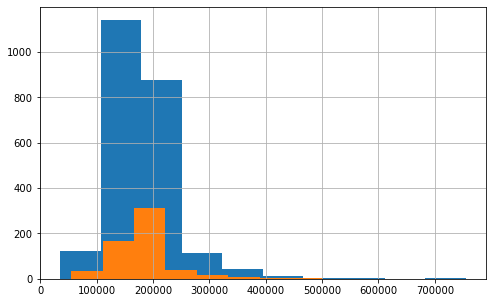

In [38]:
# one-hot encoding
obj_col = df.select_dtypes(include=['object']).columns
one_hot_encoded_data  = pd.get_dummies(df, columns = obj_col)
one_hot_encoded_data.reset_index(drop=True,inplace=True)

# split train and test
one_hot_train = one_hot_encoded_data.sample(frac=0.8,random_state=42)
one_hot_test = one_hot_encoded_data.drop(one_hot_train.index.to_list())

# save to csv
one_hot_train.to_csv('original_data/train_one_hot.csv') 
one_hot_test.to_csv('original_data/test_one_hot.csv') 

# check hist train and test
one_hot_train.SalePrice.hist()
one_hot_test.SalePrice.hist()

### - synth data

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [04:14<00:00,  1.96it/s]


,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,KSComplement,Inverted Kolmogorov-Smirnov D statistic,0.692178,0.692178,0.0,1.0,MAXIMIZE,None
1,CSTest,Chi-Squared,0.992720,0.992720,0.0,1.0,MAXIMIZE,None


eval score: 0.8424


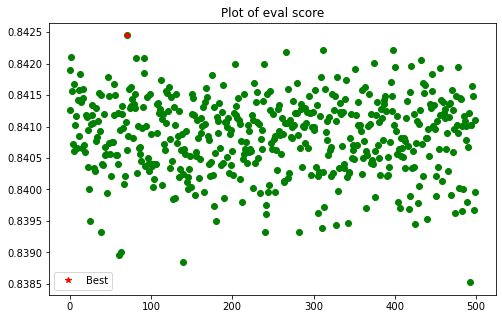

CPU times: total: 9min 11s
Wall time: 4min 17s


In [27]:
%%time

# synthetic data -> creaing synth data to improve model performance
data = df.copy()
model = GaussianCopula()
model.fit(data)

# loop of synth df and their evaluation, num_loop = number of evaluation df
num_loop = 500  
dict_eval = {}

for i in tqdm(range(num_loop)):
    df_sample = model.sample(len(data))
    eval_score = evaluate(df_sample, data)
    dict_eval[i] = (df_sample,eval_score)

# number_dict: index of best eval score dataset
number_dict = np.argmax([dict_eval[k][1] for k in dict_eval])
data_synth = dict_eval[number_dict][0]
eval_score_synth = evaluate(data_synth, data)

display(evaluate(data_synth, data, aggregate=False))
print(f'eval score: {round(eval_score_synth,4)}')

# plot scatter eval score 
yy = [dict_eval[k][1] for k in dict_eval]
xx = [j for j in range(num_loop)]
x_best = number_dict
y_best = eval_score_synth
plt.rcParams["figure.figsize"] = (8,5)
plt.scatter(xx,yy,color='green')
plt.title('Plot of eval score')
plt.plot(x_best,y_best,'r*',label='Best')
plt.legend(loc='lower left')
plt.show()



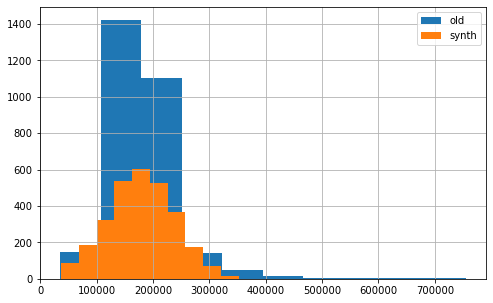

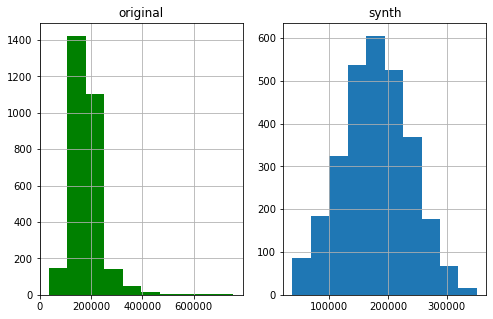

In [19]:
# histogram 
plt.rcParams["figure.figsize"] = (8,5)
data.SalePrice.hist(label='old')
df_sample.SalePrice.hist(label='synth')
plt.legend()
plt.show()

plt.rcParams["figure.figsize"] = (8,5)
plt.subplot(1, 2, 1)
data.SalePrice.hist(color='green')
plt.title('original')
plt.subplot(1, 2, 2)
df_sample.SalePrice.hist()
plt.title('synth')
plt.show()

In [28]:
len(new_data)

5784

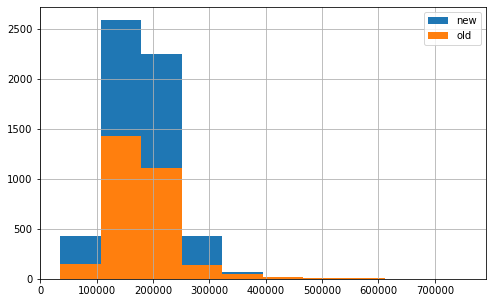

In [30]:
new_data = pd.merge(df, data_synth, how='outer')

# check synth data hist
new_data.SalePrice.hist(label='new')
data.SalePrice.hist(label='old')
plt.legend()
plt.show()

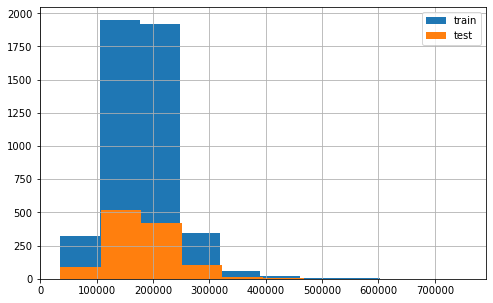

In [37]:
# one-hot encoding
obj_col = new_data.select_dtypes(include=['object']).columns
one_hot_encoded_data_synth  = pd.get_dummies(new_data, columns = obj_col)

one_hot_encoded_data_synth.reset_index(drop=True,inplace=True)

# split train and test
train_synth = one_hot_encoded_data_synth.sample(frac=0.8,random_state=42)
test_synth = one_hot_encoded_data_synth.drop(train_synth.index.to_list())

# check hist train and test
train_synth.SalePrice.hist(label='train')
test_synth.SalePrice.hist(label='test')
plt.legend()
plt.show()


# save to csv
train_synth.to_csv('synth_data/train_synth.csv') 
test_synth.to_csv('synth_data/test_synth.csv') 